A.S. Lundervold, 150119. 

# Introduksjon

Se slides fra mandag 14. januar for en introduksjon til beslutningstrær, ensembling og random forests.

Denne notebooken er ment å støtte opp under introduksjonen ved å kort vise hvordan beslutningstrær og random forests konstrueres i scikit-learn.

# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data

Vi bruker et velkjent benchmark data set, **breast cancer wisconsin**:

In [2]:
from sklearn.datasets import load_breast_cancer

breast_dataset = load_breast_cancer()

print(breast_dataset['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Vi kan gjøre dette om til en data frame:

In [3]:
breast = pd.DataFrame(breast_dataset['data'], columns=breast_dataset['feature_names'])
breast['target'] = breast_dataset['target']

...og undersøke datasettet på vanlig vis:

In [4]:
breast.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

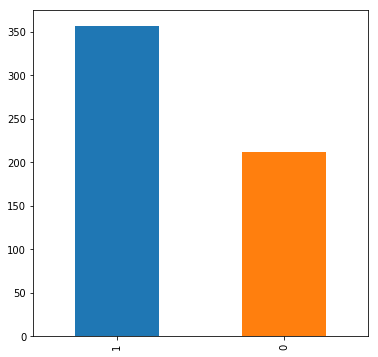

In [6]:
target_value_count = breast['target'].value_counts()

target_value_count.plot.bar(figsize=(6,6))
plt.show()

Som forventet er det et litt skjevfordelt datasett.

Hva med korrelasjoner?

In [7]:
correlation_matrix = breast.corr()
correlation_matrix['target'].sort_values(ascending=False)

target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
mean smoothness           -0.358560
concave points error      -0.408042
mean texture              -0.415185
worst symmetry            -0.416294
worst smoothness          -0.421465
worst texture             -0.456903
area error                -0.548236
perimeter error           -0.556141
radius error              -0.567134
worst compactness         -0.590998
mean compactness          -0.596534
worst concavity           -0.659610
mean concavity            -0.696360
mean area                 -0.708984
mean radius               -0.730029
worst area                -0.733825
mean perimeter            -0.742636
worst radius              -0

Vi ser at mange features er sterkt (negativt) korrelert med target. 

Vi lager vår X og y og splitter i trening og test:

In [8]:
X = breast.drop('target', axis=1)
y = breast['target']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Beslutningstrær (decision trees)

Her er et plot av to features versus target:

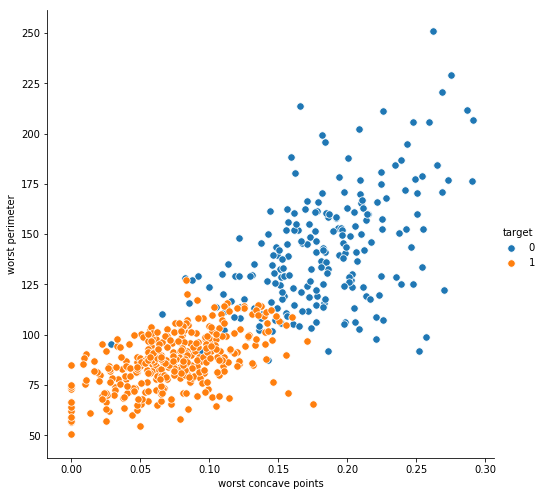

In [10]:
sns.pairplot(x_vars = 'worst concave points', y_vars = 'worst perimeter', data=breast, hue='target', 
             height=7, plot_kws={"s": 55} # Size of markers
            )
plt.show()

Vi kan bytte ut hvilke to features vi plotter:

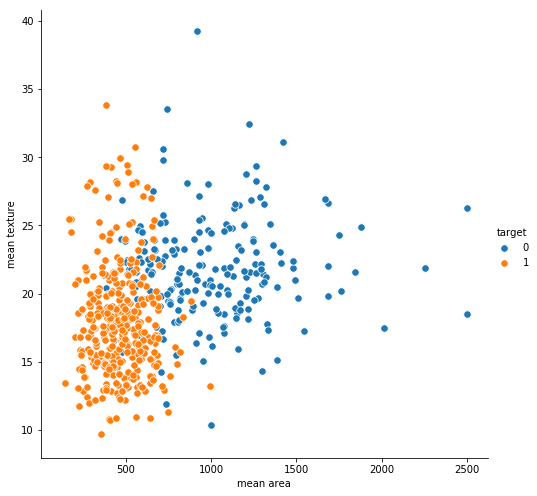

In [11]:
sns.pairplot(x_vars = 'mean area', y_vars = 'mean texture', data=breast, hue='target', 
             height=7, plot_kws={"s": 55} # Size of markers
            )
plt.show()

Vi merker at for disse par av features har instanser markert som brystkreft høyere "worst concave points" og høyere "worst perimeter" enn de markert som negative. Det samme gjelder for "mean area", men i mindre grad for "mean texture". 

For å avgjøre hvorvidt en person har brystkreft eller ikke kunne vi derfor laget et sett med regler med ting som

* "Dersom worst concave points er over 0.13 og worst perimeter samtidig er over 120, prediker brystkreft."<br>
* "Dersom mean area er over 1000 og mean texture over 17, prediker brystkreft."
* og så videre

Ved å dra inn flere features samtidig kunne våre regler blitt enda bedre. 

> **Et slikt sett av regler er nøyaktig et beslutningstre!**

Vi kan la scikit-learn bygge treet for oss, og da med alle features:

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42) 

In [14]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [15]:
from IPython.display import display
from IPython.display import SVG
from sklearn.tree import export_graphviz

In [16]:
#from graphviz import Source
#graph = Source(export_graphviz(tree_clf, out_file=None, feature_names=X_train.columns, 
#                               class_names=['not cancer','cancer'], filled = True, rounded=True))

In [17]:
#graph.save('assets/decision_tree_cancer.dot')
#!dot assets/decision_tree_cancer.dot -Tpng > assets/decision_tree_cancer.png

In [18]:
#display(SVG(graph.pipe(format='svg')))

***NB: Cellen over krever at graphviz er installert på din maskin. Kjør koden nedenfor for å hente inn output som et bilde***

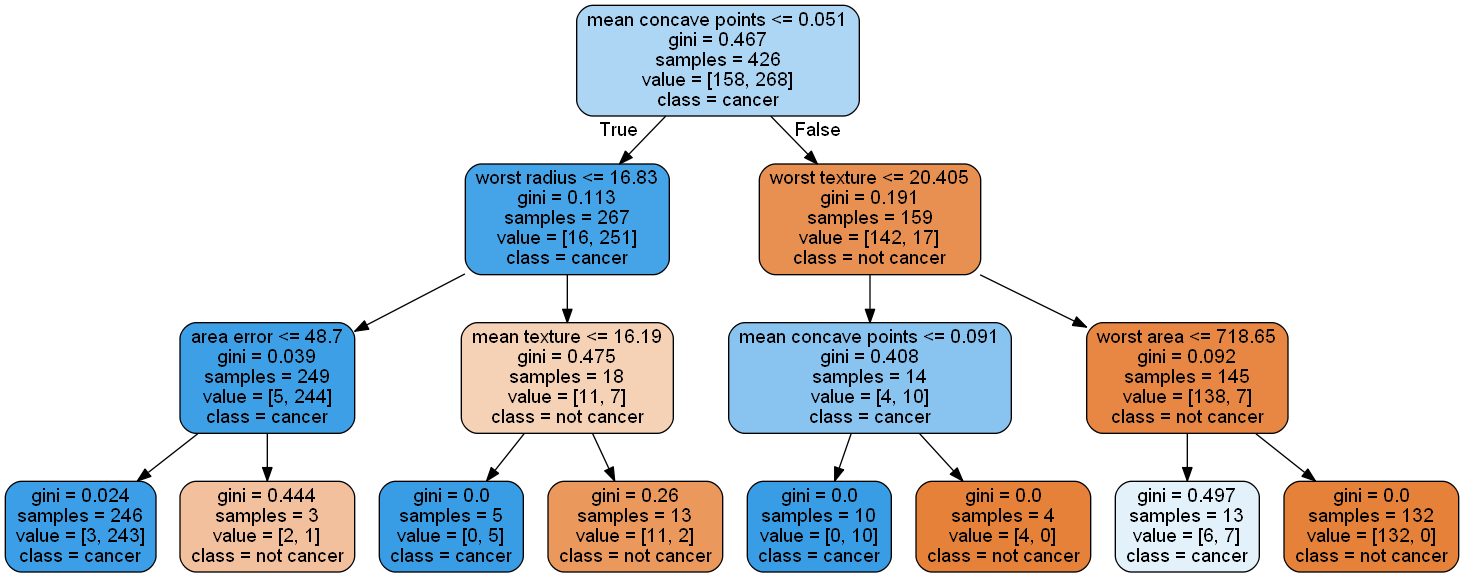

In [19]:
import IPython
IPython.display.Image("assets/decision_tree_cancer.png", width='100%')

## Evaluering

Hvor godt gjør modellen det? 

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
y_pred = tree_clf.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)

0.958041958041958

Hva med dens feil? Er det mange falske negative for eksempel?

In [23]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

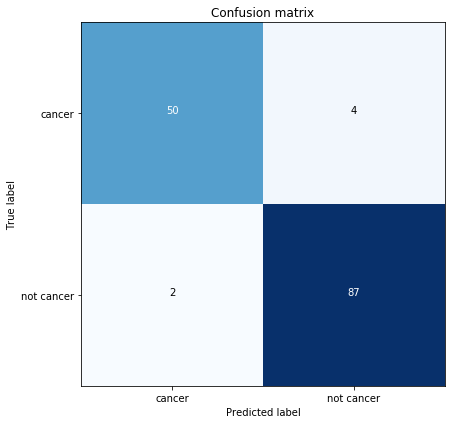

In [24]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['cancer', 'not cancer'])

## Beslutningsgrenser

Vi kan plotte hvordan scikit-learns regler splitter cancer fra ikke-cancer med featuresene vi valgte tidligere.

In [25]:
from utils import plot_decision_boundary

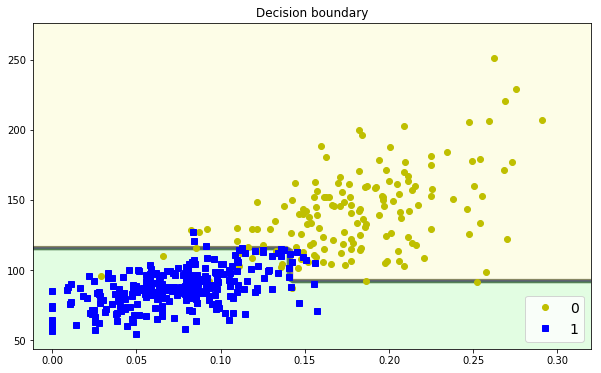

In [26]:
X_small = breast[['worst concave points', 'worst perimeter']]
y_small = breast['target']

X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, random_state=42
                                                                   )
tree_clf_small = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_small.fit(X_small_train, y_small_train)

_ = plot_decision_boundary(tree_clf_small, X_small_train, y_small_train)

Om vi øker dybden på treet får vi følgende:

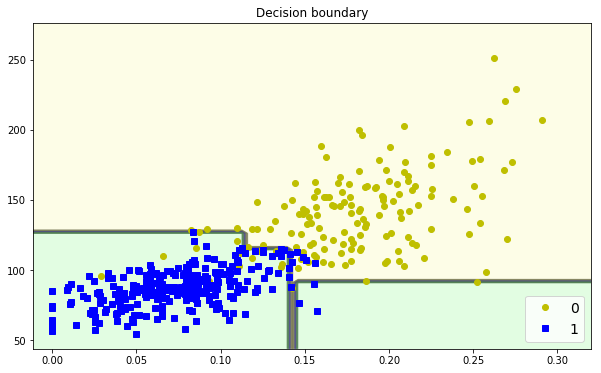

In [27]:
tree_clf_small_deep = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf_small_deep.fit(X_small_train, y_small_train)

_ = plot_decision_boundary(tree_clf_small_deep, X_small_train, y_small_train)

Vi ser at med dypere trær blir reglene til treet *veldig* spesifikke, slik at det blir i stand til å skille så mange av instansene fra hverandre som mulig. 

Dette kalles **overfitting**: modellen prøver "for hardt" å tilpasse seg data, og får derfor dårligere evne til å **generalisere** til nye data (les: nye pasienter). 

Vi kan se det ved å sjekke modellens prediksjoner på usette instanser:

In [28]:
y_pred_small = tree_clf_small.predict(X_small_test)
y_pred_small_deep = tree_clf_small_deep.predict(X_small_test)

In [29]:
print(f"Accuracy til første tre: {accuracy_score(y_small_test, y_pred_small)}")
print(f"Accuracy til dypere tre: {accuracy_score(y_small_test, y_pred_small_deep)}")

Accuracy til første tre: 0.9440559440559441
Accuracy til dypere tre: 0.9370629370629371


Modellen gjør det dårligere på testdata enn vår den med mindre dybde, selv om den er bedre tilpasset treningsdata.  

Beslutningstrær som får vokse fritt vil alltid overfitte data. Derfor er det viktig å kontrollere `max_depth` og/eller sette andre begrensinger på trærne. 

Et annet problem med beslutningstrær er at de kan være **veldig ustabile**: en liten endring i data som brukes til trening kan gi veldig ulikt tre. 

> For å bekjempe disse begreningsingene og samtidig beholde mange av de fine egenskapene til beslutningstrær, kan man *ensemble*, det vil si sette sammen, mange trær til én modell. Dette leder en til **random forests**.

# Random forests: ensembles av beslutningstrær

En random forest er et **ensemble** av beslutningstrær. Ensembling er egentlig en mer generell teknikk, anvendbar for alle maskinlæringsmodeller.

Ensembling kan motiveres fra konseptet ***wisdom of the crowd***. I mange situasjoner vil en gruppe ikke-eksperter som kombinerer sine prediksjoner utkonkurrere individuelle eksperter. 

Ideen er selvsagt ikke ny. Her er Aristoteles tilbake i 350 BCE:

> For the many, of whom each individual is but an ordinary person, when they meet together may very likely be better than the few good, if regarded not individually but collectively, just as a feast to which many contribute is better than a dinner provided out of a single purse 
– Aristotle, Politics Book III

Vi skal fokusere på ensembling nøyaktig slik det brukes for random forests, men vit at det er en mer generell og svært nyttig teknikk i maskinlæring. 

Som vi har diskutert, beslutningstrær kan enkeltvis være svært sensitive til den eksakte treningsdataen som brukes, og de har det også med å "overfitte" treningsdata.

Ved å trene flere beslutningstrær hver på litt ulike deler av treningsdata kan hvert enkelt tre være sensitivt, men ved å ta gjennomsnittet av deres prediksjoner kan sensitiviteten reduseres og overfitting-tendensen reduseres. 

La oss si vi ønsker å bygge 500 trær på et treningssett med `n_samples` datapunkt. Hvert tre bygges som følger: 

1. Trekk et datapunkt tilfeldig fra treningsdata. Gjør dette `n_samples` ganger, med tilbakelegging. Altså inntil du har `n_samples` datapunkter. Dette kalles **bootstrap sampling**. Hvert tre vil bli konstruert på ulike datasett. 
2. Tren et beslutningstre på dette datasettet, men ved hver node velg et tilfeldig utvalg av features som treet får vurdere å splitte på, inntil `max_features` antall (et antall vi velger). Hvert tre konstrueres altså basert på ulike features. 

Dette er en random forest. 

<img width=60% src="assets/rf_datacamp.PNG">

Prediksjoner fra en random forest gjøres ulikt for klassifikasjon og regresjon:

**Regresjon:** La hvert tre komme med sin prediksjon. Ta deretter gjennomsnittet av disse. <br>
**Klassifikasjon:** La hvert tre komme med sin prediksjon, og kombiner dem ved avstemning, hvor du tar hensyn til hvor sikker hvert tre er på sin prediksjon. Hvert tre produserer en sannsynlighet knyttet til sin prediksjon. Ta gjennomsnittet av disse og prediker klassen med høyest gjennomsnittlig sannsynlighet. 

Vi kan bygge en random forest med scikit-learn:

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42)

In [32]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:
rf.score(X_test, y_test)

0.972027972027972

Vi oppnådde en bedre accuracy med disse 500 beslutningstrærne satt sammen i en random forest enn med vårt enkelt-tre fra tidligere:

In [34]:
tree_clf.score(X_test, y_test)

0.958041958041958

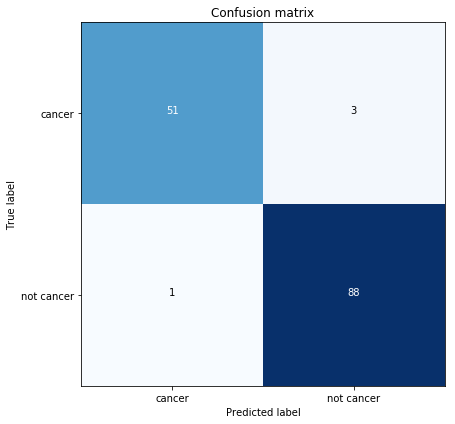

In [35]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['cancer', 'not cancer'])